## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

In [2]:
tStart_notebook = time.time()

## user settings

In [3]:
meshDim = 50 
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 5

eval_mode = "gaussian"

dt = 0.04

## Model problem

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
fom_transient = FOM_advectiondiffusion(meshDim=meshDim, dt=dt, final_time=4)

In [5]:
para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_transient, grid_t = fom.implicit_Euler(m_init=m, dt=dt, final_time=4)
sol_steadystate = fom.solve_steady(forcing=m)

## Measurements

In [6]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters, eval_mode=eval_mode)
pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters)

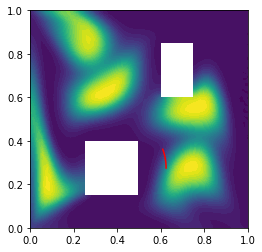

In [7]:
t = 0.5
k = np.argmin(np.abs(grid_t - t))
dl.plot(sol_transient[k], mesh=fom.mesh)
plt.plot(pos[:k, 0], pos[:k, 1], color="r")

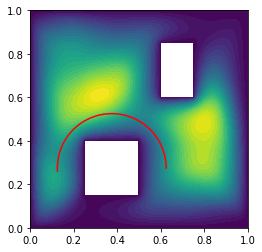

In [8]:
dl.plot(sol_steadystate, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

In [9]:
slicer = 1

tStart = time.time()

d_steadystate_gaussian = drone.measure(pos[::slicer, :], sol_steadystate, mode="gaussian")
d_steadystate_pointwise = drone.measure(pos, sol_steadystate, mode="point-eval")
d_steadystate_uniform = drone.measure(pos[::slicer, :], sol_steadystate, mode="uniform")

print("Runtime for half this block: {} min".format((time.time()-tStart)/60))

d_transient_gaussian = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="gaussian")
d_transient_pointwise = drone.measure(pos, sol_transient, mode="point-eval")
d_transient_uniform = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="uniform")

print("Runtime for this block: {} min".format((time.time()-tStart)/60))

Runtime for half this block: 5.127750996748606 min


/Users/nicole/anaconda3/envs/m2dt_oed_FEniCS/lib/python3.10/site-packages/ufl/exproperators.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


Runtime for this block: 5.355181113878886 min


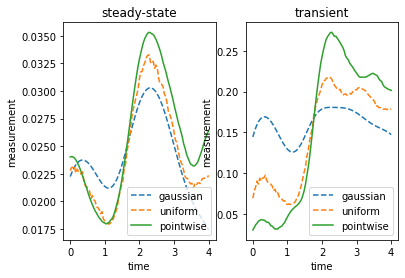

In [10]:
fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t[::slicer], d_steadystate_gaussian, label="gaussian", linestyle = "--")
axs[0].plot(grid_t[::slicer], d_steadystate_uniform, label="uniform", linestyle = "--")
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t[::slicer], d_transient_gaussian, label="gaussian", linestyle = "--")
axs[1].plot(grid_t[::slicer], d_transient_uniform, label="uniform", linestyle = "--")
axs[1].plot(grid_t, d_transient_pointwise, label="pointwise")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

## statistical setup

In [11]:
if eval_mode == "point-eval":
    d_steadystate = d_steadystate_pointwise
    d_transient = d_transient_pointwise
    
if eval_mode == "gaussian":
    d_steadystate = d_steadystate_gaussian
    d_transient = d_transient_gaussian
    
if eval_mode == "uniform":
    d_steadystate = d_steadystate_uniform
    d_transient = d_transient_uniform
    
d_steadystate_pointwise = None
d_transient_pointwise = None

In [12]:
prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))

noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)
noise_model_transient = NoiseModel(grid_t=grid_t, c_scaling=1e+1, c_diffusion = 0.01)

brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
brain_transient = Brain(fom=fom_transient, drone=drone, prior=prior, noise_model=noise_model_transient)

## posterior

In [13]:
print("noise-free data:")

post_steadystate = brain.compute_posterior(data = d_steadystate)
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior(data = d_transient)
print("transient mean:    ", post_transient.mean)

noise-free data:
steady-state mean:  [0.60550119 0.29672348 0.18303575 0.22999955 0.11482497]
transient mean:     [0.33198208 0.14843851 0.12219254 0.17431006 0.03484295]


noisy data:
steady-state mean:  [0.61065233 0.29688803 0.1870118  0.23169073 0.11770482]
transient mean:     [0.3375833  0.1478478  0.1250719  0.17600617 0.03629643]


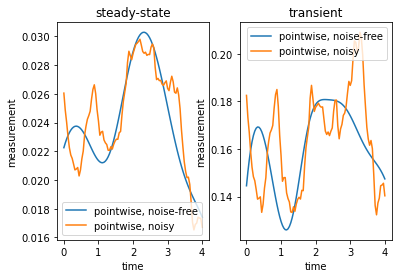

In [14]:
print("noisy data:")

noise = noise_model.sample()

post_steadystate = brain.compute_posterior(data = d_steadystate + noise)
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior(data = d_transient + 10*noise)
print("transient mean:    ", post_transient.mean)


fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t, d_steadystate, label="pointwise, noise-free")
axs[0].plot(grid_t, d_steadystate + noise, label="pointwise, noisy")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t, d_transient, label="pointwise, noise-free")
axs[1].plot(grid_t, d_transient + 10 * noise, label="pointwise, noisy")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

### marginal distribution

In [15]:
noise = noise_model.sample()

mean_steadystate = post_steadystate.compute_mean(data = d_steadystate)
mean_steadystate_noisy = post_steadystate.compute_mean(data = d_steadystate + noise)

mean_transient = post_transient.compute_mean(data = d_transient)
mean_transient_noisy = post_transient.compute_mean(data = d_transient + 10*noise)

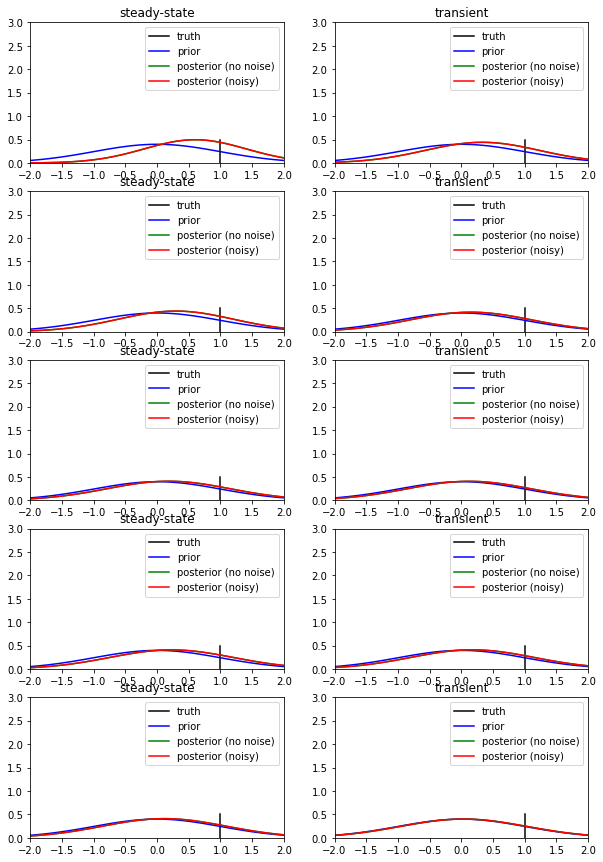

In [16]:
fig, axs = plt.subplots(n_para, 2, figsize = (10, 3*n_para))

for i in range(n_para):
    
    axs[i,0].plot([para_true[i], para_true[i]], [0, 0.5], color="black", label="truth")
    axs[i,1].plot([para_true[i], para_true[i]], [0, 0.5], color="black", label="truth")
    
    variance = prior.covar[i,i]
    sigma = math.sqrt(variance)
    x = np.linspace(prior.mean[i] - 2*sigma, prior.mean[i] + 2*sigma, 100)
    vals = stats.norm.pdf(x, prior.mean[i], sigma)
    axs[i,0].plot(x, vals, label = "prior", color = "b")
    axs[i,1].plot(x, vals, label = "prior", color = "b")
    
    # posterior, steadystate
    variance = post_steadystate.covar[i,i]
    sigma = math.sqrt(variance)
    vals = stats.norm.pdf(x, mean_steadystate[i], sigma)
    axs[i,0].plot(x, vals, label = "posterior (no noise)", color = "g")

    vals = stats.norm.pdf(x, mean_steadystate_noisy[i], sigma)
    axs[i,0].plot(x, vals, label = "posterior (noisy)", color = "r")
    
    # posterior, transient
    variance = post_transient.covar[i,i]
    sigma = math.sqrt(variance)
    vals = stats.norm.pdf(x, mean_transient[i], sigma)
    axs[i,1].plot(x, vals, label = "posterior (no noise)", color = "g")

    vals = stats.norm.pdf(x, mean_transient_noisy[i], sigma)
    axs[i,1].plot(x, vals, label = "posterior (noisy)", color = "r")
    
    
    axs[i,0].set_ylim(0, 3)
    axs[i,1].set_ylim(0, 3)
    axs[i,0].set_xlim(-2, 2)
    axs[i,1].set_xlim(-2, 2)
    axs[i,0].set_title("steady-state")
    axs[i,1].set_title("transient")
    axs[i,0].legend()
    axs[i,1].legend()
    
    #axs[i,i].set_ylim([np.min(vals), 5*np.max(vals_2)])

### Utility functions

In [17]:
print("steady-state:")
print("A-OED:", brain.eval_utility(post_steadystate, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_steadystate, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_steadystate, oed_mode="E"), "\n")

print("transient:")
print("A-OED:", brain.eval_utility(post_transient, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_transient, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_transient, oed_mode="E"), "\n")

steady-state:
A-OED: 4.324358438819741
D-OED: 0.43648749180419194
E-OED: 0.9999874037904765 

transient:
A-OED: 4.63600069620056
D-OED: 0.6662855198866421
E-OED: 0.9994248768465277 



## The End.

In [18]:
t_notebook = time.time() - tStart_notebook
print("Runtime of this notebook: {} min".format(t_notebook / 60))

Runtime of this notebook: 6.407893399397532 min
